In [70]:
import csv
import numpy as np
from google.colab import drive
import pandas as pd
import json
import ast
import matplotlib.pyplot as plt
import collections

#Main Functions

In [71]:
def reverse_counts(counts, size=20):
  """ 
  Reverses the keys of a dictionary (i.e. the characters in all the keys are reversed)

  Parameters:
  counts (dict): dictionary containing the measurement results
  size (int): the number of qubits measured

  Returns:
  reverse_counts (dict): dictionary with keys in reverse order
  """
  intermediate = {}
  for key, value in counts.items():
    rev_key = ""
    for i in range(size):
      rev_key = rev_key + key[size-i-1]
    intermediate[key] = rev_key
  reverse_counts = dict([(intermediate.get(k), v) for k, v in counts.items()])
  return reverse_counts

def get_delegated_OTP_keys(permutation, x_key, z_key, num_qubits=14, syndrome_cnots = [[14, 0], [14, 2], [14, 4], [14, 6], [15, 1], [15, 2], [15, 5], [15, 6], [16, 3], [16, 4], [16, 5], [16, 6], [17, 7], [17, 9], [17, 11], [17, 13], [18, 8], [18, 9], [18, 12], [18, 13], [19, 10], [19, 11], [19, 12], [19, 13]]):
  """ 
  Get delegated, post-processed, classical one-time pad keys for a program

  Parameters:
  permutation ([int]): permutation key
  x_key ([int]): X part of the non-delegated one-time pad key
  z_key ([int]): Z part of the non-delegated one-time pad key
  num_qubits (int): number of data qubits
  syndrome_cnots ([[int,int]]): all cnot gates used to derive error syndromes

  Returns:
  delegated_x_key ([int]): classically processed and delegated X part of one-time pad key
  delegated_z_key ([int]): classically processed and delegated Z part of one-time pad key
  """
  permuted_cnots = []
  for gate in syndrome_cnots:
    permuted_cnots.append([gate[0],permutation.index(gate[1])])

  new_x_key = x_key[:]
  new_z_key = z_key[:]

  for cnot in permuted_cnots:
    a = new_x_key[cnot[0]]
    b = new_z_key[cnot[0]]
    c = new_x_key[cnot[1]]
    d = new_z_key[cnot[1]]
    new_x_key[cnot[0]] = a
    new_z_key[cnot[0]] = b+d
    new_x_key[cnot[1]] = a+c
    new_z_key[cnot[1]] = d

  #hadamard operator delegation
  for i in range(num_qubits,num_qubits + int(num_qubits/7*3)):
    new_x_key[i], new_z_key[i] =  new_z_key[i], new_x_key[i]

  delegated_x_key = [i%2 for i in new_x_key]
  delegated_z_key = [i%2 for i in new_z_key]
  return delegated_x_key, delegated_z_key

def apply_OTP_and_unpermute(counts, permutation, x_key, z_key, num_qubits=14):
  """
  Classical processing of quantum measurement outcomes
  Includes applying the delegated one-time pad and unpermuting the circuit

  Parameters:
  counts (dict): all the measurement outcomes for a job
  permutation([int]): permutation key
  x_key ([int]): x gates part of one-time pad key
  z_key ([int]): z gates part of one-time pad key 
  num_qubits (int): number of data qubits

  Returns:
  unpermuted_steane(dict): classically post processed measurement outcomes
  """
  processed_results = {}
  for key, value in counts.items():
    new_key = ""
    for i in range(num_qubits + int(num_qubits/7*3)):
      val = int(key[i])
      k2_val = int(x_key[i])
      if k2_val == 1 and val == 0:
        new_key = new_key + "1"
      elif k2_val == 1 and val == 1:
        new_key = new_key + "0"
      else:
        new_key = new_key + str(val)
    processed_results[new_key] = value

  unpermuted_steane = {}
  for key, value in processed_results.items():
    new_key = ""
    for i in range(num_qubits):
      new_key = new_key+ key[permutation.index(i)]
    syndrome_keys=""
    for j in range(int(num_qubits/7*3)):
      syndrome_keys = syndrome_keys + key[-int(int(num_qubits/7*3)-j)]
    new_key = new_key + syndrome_keys
    # print(syndrome_keys)
    # print(new_key)
    unpermuted_steane[new_key] = value
  return unpermuted_steane

def check_correctness(counts, codeword_combos, syndrome = '000000', num_shots = 8192, num_qubits = 14):
  """ 
  Gets the correct measurement outcome rates of a job

  Parameters:
  counts (dict): all processed measurement outcomes
  codeword_combos ([str]): all codewords
  syndrome (str): the correct no error syndrome
  num_shots (int): the number of times the computation was run
  num_qubits (int): the number of data qubits

  Returns:
  bit_rate (float): rate of measurement outcomes that have no bit flips (i.e. no bit error)
  phase_rate (float): rate of measurement outcomes that have no phase flips (i.e. no phase error)
  all_rate (float): rate of measurement outcomes that have no bit or phase flips (i.e. no bit and phase error)
  """

  bit_count = 0
  phase_count = 0
  all_count = 0
  for key, val in counts.items():
    if key[:num_qubits] in codeword_combos:
      bit_count = bit_count + 1
      if key[num_qubits:] == syndrome:
        all_count = all_count +1
    if key[num_qubits:] == syndrome:
      phase_count = phase_count +1
  bit_rate = bit_count/num_shots
  phase_rate = phase_count/num_shots
  all_rate = all_count/num_shots
  return bit_rate, phase_rate, all_rate

def get_average_rates(file_name, num_tests = 5, num_iterations= 10):
  """ 
  Gets the average true positive and false positive rates for the different tests
  For tests where the challenge input is equal to the password, the average true positive rate is found.
  In all other cases, the average false positive is found.
  
  Parameters:
  file_name (str): the name of the file in which the rates for the individual rates were saved
  num_tests (int): the number of different tests performed
  num_iterations (int): the number of iterations each test was performed

  Returns:
  new_df (panda's DataFrame): contains the averages of all the tests

  """
  try:
    df = pd.read_csv(file_name)
  except Error as err:
    print("Error: ", err)
  
  new_df = pd.DataFrame()

  for i in range(num_tests):
    avgs = df[i*num_iterations:(i+1)*num_iterations].mean()
    new_df[str(i)] = avgs
  return new_df

def get_average_rates_from_random_tests(file_name, start_index, end_index):
  """ 
  Gets the average true positive and false positive rates for tests that sample random challenge inputs
  For tests where the challenge input is equal to the password, the average true positive rate is found.
  In all other cases, the average false positive is found.
  
  Parameters:
  file_name (str): the name of the file in which the rates for the individual rates were saved
  start_index (int): the location of where random tests starts according to data ordered in file_name
  end_index (int): the location of where random tests ends according to data ordered in file_name

  Returns:
  new_df (panda's DataFrame): contains the averages of the random tests

  """
  try:
    df = pd.read_csv(file_name)
  except Error as err:
    print("Error: ", err)
  new_df = pd.DataFrame()

  random_avgs = df[start_index:end_index].groupby(['is_p']).get_group(True).mean()
  new_df["True Positive"] = random_avgs
  random_avgs = df[start_index:end_index].groupby(['is_p']).get_group(False).mean()
  new_df["False Positive"] = random_avgs
  return new_df

# User Defined Values

In [72]:
drive.mount('/content/drive')

# set location for retrieving all the measurement outcome results and information
info_file = "/content/drive/My Drive/res/stripped_info.csv"
# set location for saving all the individual calculated error rates (i.e. bit, phase, and both bit and phase combined errors)
save_file = "/content/drive/My Drive/res/individual_error_rates.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
df = pd.read_csv(info_file)
all_key1 = df.challenge_key_1.to_list()
all_key2 = df.challenge_key_2.to_list()
is_point = df.is_point.to_list()

In [74]:
fields = ['#', 'is_p','no_bit_flip_percentage', 'no_phase_flip_percentage', 'no_error_percentage']
stats = pd.DataFrame(columns=fields)

In [75]:
first_steane_codewords = ['0000000','1010101','0110011','1100110','0001111','1011010','0111100','1101001']
second_steane_codewords = ['0000000', '1110000', '1001100', '0111100', '0101010', '1011010', '1100110', '0010110', '1101001', '0011001', '0100101', '1010101', '1000011', '0110011', '0001111', '1111111']
# the codewords of our Steane encoded program
codeword_combos = [x+y for x in first_steane_codewords for y in second_steane_codewords]

# Calculate Error Rates 

## Option 1: Calculating Rates From File



Calculate the true positive and false positive rates for all test results from a file containing all the raw counts.



In [76]:
# set location of data file containing a list of raw counts only
# format of file: "["{'00000000000000000000':8192}"]"
data = "/content/drive/My Drive/res/secondary/raw_counts_data.txt"

In [77]:
raw_data = ""
with open(data) as f:
  raw_data = f.read()
raw_data = ast.literal_eval(raw_data)

index = 0
for x in raw_data:
  raw = ast.literal_eval(x)
  counts = reverse_counts(raw)
  key1 = ast.literal_eval(all_key1[index])
  key2 = ast.literal_eval(all_key2[index])
  xkey = key2[0] + [0]*6
  zkey = key2[1] + [0]*6
  x_key, z_key = get_delegated_OTP_keys(key1, xkey, zkey)
  processed_counts = apply_OTP_and_unpermute(counts, key1, x_key, z_key)
  bit, phase ,all = check_correctness(processed_counts, codeword_combos)
  print(is_point[index], bit, phase, all)
  stats.loc[index] = [index, is_point[index], bit, phase, all]
  index = index +1

True 0.021240234375 0.0174560546875 0.0001220703125
True 0.0284423828125 0.020751953125 0.0001220703125
True 0.020751953125 0.013671875 0.0001220703125
True 0.02587890625 0.0128173828125 0.0003662109375
True 0.02294921875 0.0137939453125 0.000244140625
True 0.0377197265625 0.0157470703125 0.000732421875
True 0.025390625 0.0107421875 0.00048828125
True 0.0308837890625 0.0169677734375 0.0008544921875
True 0.029052734375 0.0146484375 0.0003662109375
True 0.0250244140625 0.0203857421875 0.000244140625
False 0.015625 0.0166015625 0.0001220703125
False 0.016357421875 0.014404296875 0.0001220703125
False 0.0211181640625 0.018310546875 0.0006103515625
False 0.01318359375 0.017578125 0.0001220703125
False 0.015625 0.0152587890625 0.0001220703125
False 0.0185546875 0.0152587890625 0.0001220703125
False 0.0146484375 0.013671875 0.00048828125
False 0.0130615234375 0.0174560546875 0.00048828125
False 0.0225830078125 0.0181884765625 0.00048828125
False 0.0106201171875 0.0194091796875 0.0
False 0.017

In [78]:
stats.to_csv(save_file)

In [79]:
print(stats)

     #   is_p  ...  no_phase_flip_percentage  no_error_percentage
0    0   True  ...                  0.017456             0.000122
1    1   True  ...                  0.020752             0.000122
2    2   True  ...                  0.013672             0.000122
3    3   True  ...                  0.012817             0.000366
4    4   True  ...                  0.013794             0.000244
5    5   True  ...                  0.015747             0.000732
6    6   True  ...                  0.010742             0.000488
7    7   True  ...                  0.016968             0.000854
8    8   True  ...                  0.014648             0.000366
9    9   True  ...                  0.020386             0.000244
10  10  False  ...                  0.016602             0.000122
11  11  False  ...                  0.014404             0.000122
12  12  False  ...                  0.018311             0.000610
13  13  False  ...                  0.017578             0.000122
14  14  Fa

## Option 2: Calculating Rates from A Single Set of Measurement Outcomes


Calculate the true positive and false positive rates for all test results from a single job's measurement outcomes

In [80]:
# set the index of the job
index = 10

In [81]:
# set a single job's measurement counts
raw = {}

In [82]:
counts = reverse_counts(raw)
key1 = ast.literal_eval(all_key1[index])
key2 = ast.literal_eval(all_key2[index])
xkey = key2[0] + [0]*6
zkey = key2[1] + [0]*6

del_x_key, del_z_key = get_delegated_OTP_keys(key1, xkey, zkey)
processed_counts = apply_OTP_and_unpermute(counts, key1, del_x_key, del_z_key)
bit, phase, all = check_correctness(processed_counts,codeword_combos)
stats.loc[index] = [index, is_point[index], bit, phase, all]

In [83]:
print(stats)

     #   is_p  ...  no_phase_flip_percentage  no_error_percentage
0    0   True  ...                  0.017456             0.000122
1    1   True  ...                  0.020752             0.000122
2    2   True  ...                  0.013672             0.000122
3    3   True  ...                  0.012817             0.000366
4    4   True  ...                  0.013794             0.000244
5    5   True  ...                  0.015747             0.000732
6    6   True  ...                  0.010742             0.000488
7    7   True  ...                  0.016968             0.000854
8    8   True  ...                  0.014648             0.000366
9    9   True  ...                  0.020386             0.000244
10  10  False  ...                  0.000000             0.000000
11  11  False  ...                  0.014404             0.000122
12  12  False  ...                  0.018311             0.000610
13  13  False  ...                  0.017578             0.000122
14  14  Fa

# Calculate Average Error Rates 

In [84]:
df = get_average_rates(save_file, num_tests = 5, num_iterations= 10)
print(df)

                                 0          1          2          3          4
Unnamed: 0                4.500000  14.500000  24.500000  34.500000  44.500000
#                         4.500000  14.500000  24.500000  34.500000  44.500000
is_p                      1.000000   0.000000   0.000000   0.000000   0.000000
no_bit_flip_percentage    0.026733   0.016138   0.016113   0.025989   0.016125
no_phase_flip_percentage  0.015698   0.016614   0.015100   0.015881   0.015076
no_error_percentage       0.000366   0.000269   0.000232   0.000415   0.000269


In [85]:
df = get_average_rates_from_random_tests(save_file, 50, 60)
print(df)

                          True Positive  False Positive
Unnamed: 0                    52.200000       56.800000
#                             52.200000       56.800000
is_p                           1.000000        0.000000
no_bit_flip_percentage         0.029224        0.007886
no_phase_flip_percentage       0.015747        0.016187
no_error_percentage            0.000391        0.000098


#Graphing results example

In [86]:
# no error phase syndrome
phase_syndrome = '000000'
# set the post-processed measurement outcomes
counts_dict = {}
num_qubits = 14

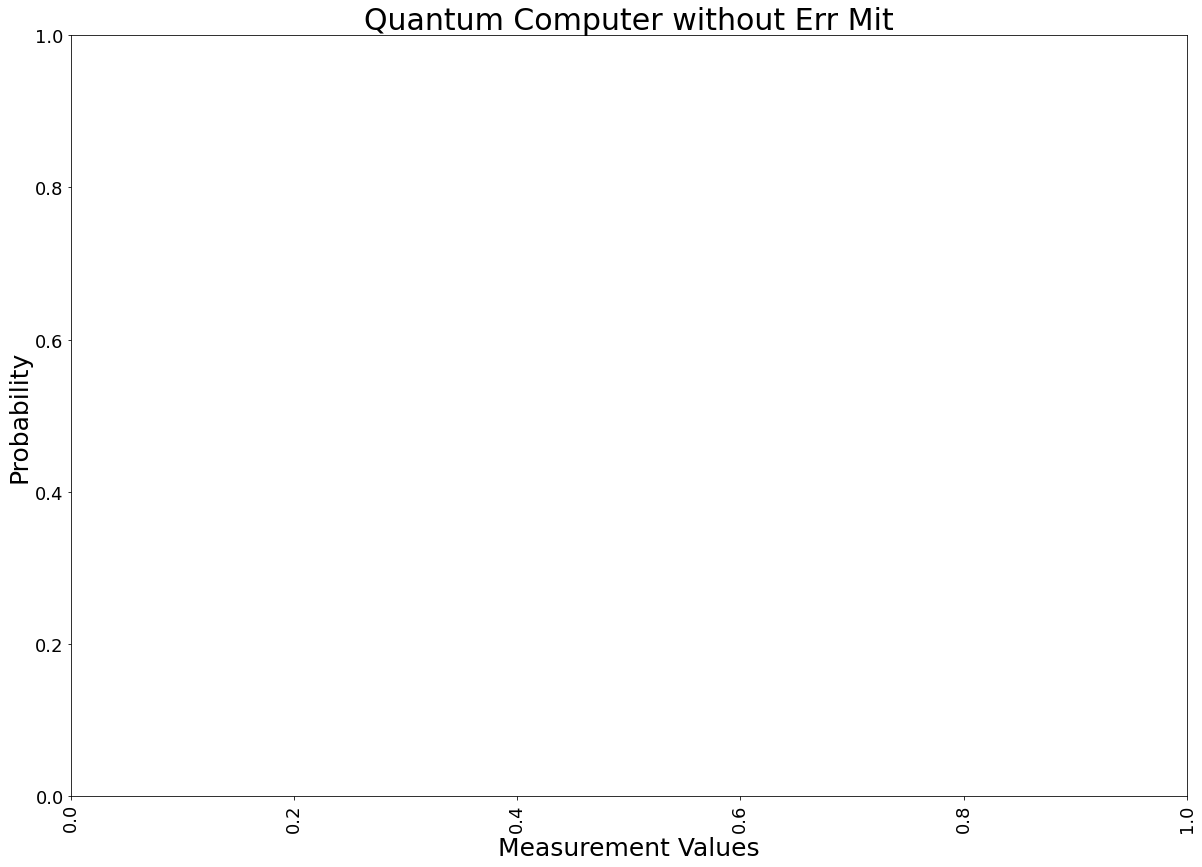

In [87]:
d = collections.OrderedDict(sorted(counts_dict.items()))
count = 0
# set color of all the wrong measurement outcomes
colors = ['lightgray']*len(d)
patterns = ['']*len(d)
for key, val in d.items():
  if phase_syndrome == key[-num_syndrome:]:
    if key[:num_qubits] in codeword_combos:
      # set color of all the right measurement outcomes
      colors[count]= "black"
  count = count +1 
x_vals = list(d.keys())
y_vals = list(d.values())

plt.figure(figsize=(20,14))
for i in range(len(d)):
  plt.bar(x_vals[i], y_vals[i], color=colors[i])
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.xlabel('Measurement Values', fontsize=25)
plt.ylabel('Probability', fontsize=25)
plt.title('Quantum Computer without Err Mit', fontsize=30)
plt.show()